# 딥러닝 학습 기술

- Optimization (매개변수 갱신(확률적 경사하강법, 모멘텀, AdaGrad, Adam) )

- Weight Decay
- Batch Normalization
- 과대적합(Overfitting) / 과소적합(Underfitting)
- 규제화(Regularization)
- 드롭아웃(Drop Out)
- 하이퍼 파라미터
  - 학습률(Learning Rate)
  - 학습횟수
  - 미니배치 크기



## 최적화 방법 : 매개변수 갱신

### 확률적 경사하강법(Stochastic Gradient Descent, SGD)

  - 전체를 한번에 계산하지 않고, **확률적**으로 일부 샘플을 뽑아 조금씩 나누어 학습을 시키는 과정  
  
  - 반복할 때마다 다루는 데이터의 수가 적기때문에 한 번 처리하는 속도는 빠름  

  - 한 번 학습할 때 필요한 메모리만 있으면 되므로 매우 큰 데이터셋에 대해서도 학습이 가능

  - 확률적이기 때문에, 배치 경사하강법보다 불안정

  - 손실함수의 최솟값에 이를 때까지 다소 위아래로 요동치면서 이동

  - 따라서, 위와 같은 문제 때문에 **미니 배치 경사하강법**(mini-batch gradient descent)로 학습을 진행  
    요즘에는 보통 SGD라고하면 미니 배치 경사하강법을 의미하기도 함

  
  - (참고)
    - <code>배치 경사하강법</code>
    - <code>미니 배치 경사하강법</code>
    - <code>확률적 경사하강법</code>
  
  <br>

  ## $\quad W \leftarrow W - \gamma \frac{\partial L}{\partial W}$  
   - $\gamma :\ $ 학습률

  <br>

![](https://engmrk.com/wp-content/uploads/2018/04/Fig2.png)
<sub>출처: https://engmrk.com/mini-batch-gd/</sub>


  





In [6]:
class SGD():
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [820]:
# optimizer = SGD()

# for i in range(10000):
#     optimizer.update(params, grads)

### SGD의 단점
- 단순하지만, 문제에 따라서 시간이 매우 오래걸림

### 모멘텀(Momentum)
- 운동량을 의미, 관성과 관련

- 공이 그릇의 경사면을 따라서 내려가는 듯한 모습

- 이전의 속도를 유지하려는 성향  
  경사하강을 좀 더 유지하려는 성격을 지님

- 단순히 SGD만 사용하는 것보다 적게 방향이 변함
  
![](https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-1-4842-4470-8_33/MediaObjects/463852_1_En_33_Fig1_HTML.jpg)

<sub>출처: https://link.springer.com/chapter/10.1007/978-1-4842-4470-8_33</sub>

$
\qquad v \ \leftarrow \ \alpha \ v - \gamma \ \frac{\partial L}{\partial W} \\
\qquad W \ \leftarrow \ W \ + \ v
$

  - $\alpha\ $ : 관성계수

  - $v$ :  속도

  - $\gamma\ $ : 학습률

  - $\frac{\partial L}{\partial W}\ $ : 손실함수에 대한 미분


In [821]:
import numpy as np

In [822]:
class Momentum():
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

### AdaGrad(Adaptive Gradient)
- **가장 가파른 경사를 따라 빠르게 하강하는 방법**

- 적응적 학습률이라고도 함
  학습률을 **변화시키며 진행**

- 경사가 급할 때는 빠르게 변화,  
  완만할 때는 느리게 변화

- 간단한 문제에서는 좋을 수는 있지만 딥러닝(Deep Learning)에서는 자주 쓰이지 않음
  학습률이 너무 감소되어 전역최소값(global minimum)에 도달하기 전에   
  학습이 빨리 종료될 수 있기 때문


<br>

$
\qquad h \ \leftarrow \  h + \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W} \\
\qquad W \ \leftarrow \ W \ + \gamma \frac{1}{\sqrt h} \ \frac{\partial L}{\partial W}
$

  <br>

  - $h\ $ : 기존 기울기를 제곱하여 더한 값

  - $\gamma\ $ : 학습률

  - $\frac{\partial L}{\partial W}\ $ : $W$에 대한 미분

  <br>

  - (참고)  
    - 과거의 기울기를 제곱하여 계속 더해하기 때문에  
      학습을 진행할수록 갱신 강도가 약해짐($\because \frac{1}{\sqrt h}$)    
  

In [823]:
class AdaGrad():
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### RMSProp (Root Mean Square Propagation)
- AdaGrad를 보완하기 위한 방법으로 등장

- 합 대신 지수의 평균값을 활용

- 학습이 안되기 시작하면 학습률이 커져 잘 되게끔하고,  
  학습률이 너무 크면 학습률을 다시 줄임


<br>

$
\qquad h \ \leftarrow \  \rho \ h + (1 - \rho)\ \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W} \\
\qquad W \ \leftarrow \ W \ + \gamma \frac{\partial L}{\partial W} / \ \sqrt{h + \epsilon}
$

  <br>

  - $h\ $ : 기존 기울기를 제곱하여 업데이트 계수를 곱한 값과 업데이트 계수를 곱한 값을 더해줌

  - $\rho\ $ : 지수 평균의 업데이트 계수

  - $\gamma\ $ : 학습률

  - $\frac{\partial L}{\partial W}\ $ : $W$에 대한 미분

In [824]:
class RMSprop():
    def __init__(self, lr=0.01, dr=0.99):
        self.lr = lr
        self.dr = dr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] *= self.dr
            self.h[key] += (1 - self.dr) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### Adam (Adaptive moment estimation)
- 모멘텀 최적화와 RMSProp의 아이디어를 합친 것

- 지난 그래디언트의 지수 감소 평균을 따르고(Momentum), 지난 그레디언트 제곱의 지수 감소된 평균(RMSProp)을 따름

- 가장 많이 사용되는 최적화 방법


<br>

$
\qquad t \ \leftarrow \ t + 1 \\
\qquad m_t \ \leftarrow \  \beta_1 \ m_{t-1} - (1 - \beta_1)\ \frac{\partial L}{\partial W}  \\
\qquad v_t \ \leftarrow \ \beta_2 \ v_{t-1} + (1 - \beta_2) \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W} \\
\qquad \hat{m_t} \ \leftarrow \frac{m_t}{1 - \beta_1^t} \\
\qquad \hat{v_t} \ \leftarrow \frac{v_t}{1 - \beta_2^t} \\
\qquad W_t \ \leftarrow \ W_{t-1} \ + \gamma \ \hat{m_t}\  / \sqrt{\hat{v_t} + \epsilon}
$

  <br>

  - $\beta\ $ : 지수 평균의 업데이트 계수

  - $\gamma\ $ : 학습률

  - $\beta_1 \approx 0.9\ ,\ \ \beta_2 \approx 0.999$

  - $\frac{\partial L}{\partial W}\ $ : $W$에 대한 미분

In [825]:
class Adam():
    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999):
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta_2 ** self.iter) / (1.0 - self.beta_1 ** self.iter)

        for key in params.keys():
            self.m[key] += (1 - self.beta_1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta_2) * (grads[key] ** 2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

## 최적화 방법 비교 (예, Linear Regression)

<img src="https://user-images.githubusercontent.com/11681225/50016682-39742a80-000d-11e9-81da-ab0406610b9c.gif" width="600">

<sub>출처: https://github.com/ilguyi/optimizers.numpy</sub>

## AI 두 번째 위기 (가중치 소실, Gradient Vanishing)

- 활성화함수가 Sigmoid 함수 일 때, 은닉층의 갯수가 늘어 날수록  
  가중치가 역전파되면서 가중치 소실문제 발생
  - 0 ~ 1 사이의 값으로 출력되면서 0 또는 1에 가중치 값이 퍼짐  
    이는 <u>미분값이 점점 0에 가까워짐</u>을 의미하기도 한다.

  - **ReLU 함수 등장(비선형 함수)**

- 가중치 초기화 문제(은닉층의 활성화값 분포)
  - 가중치의 값이 일부 값으로 치우치게 되면  
    활성화 함수를 통과한 값이 치우치게 되고, 표현할 수 있는 신경망의 수가 적어짐.

  - 따라서, 활성화값이 골고루 분포되는 것이 중요!

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F278186%2Fd158ec3585bc1551d9f3a03ae13a3a73%2Fvanishing%20gradient%20problem.png?generation=1574233763365617&alt=media)

<sub>출처: https://www.kaggle.com/getting-started/118228</sub>

## 가중치 초기화

* https://www.deeplearning.ai/ai-notes/initialization/

### 초기값 : 0 (zeros)

- 학습이 올바르게 진행되지 않음

- 0으로 설정하면  
  오차역전파법에서 모든 가중치의 값이 똑같이 갱신됨

In [826]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 50)
nodes = 50
hideen_layers = 6
activation_values = {}

for i in range(hideen_layers):
    if i != 0:
        x = activation_values[i - 1]
    
    w = np.zeros((nodes, nodes))
    a = np.dot(x, w)
    z = sigmoid(a)
    activation_values[i] = z

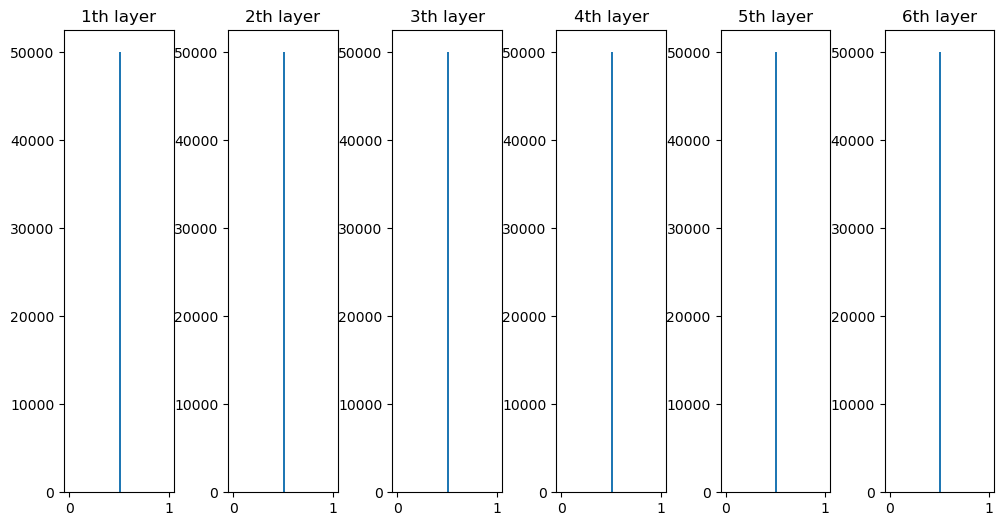

In [827]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, a in activation_values.items():
    plt.subplot(1, len(activation_values), i + 1)
    plt.title(f"{i + 1}th layer")
    plt.hist(a.flatten(), bins=50, range=(0, 1))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

### 초기값 : 균일분포(Uniform)
- 활성화 값이 균일하지 않음(활성화함수 : sigmoid)

- 역전파로 전해지는 기울기값이 사라짐

In [828]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 50)
nodes = 50
hideen_layers = 6
activation_values = {}

for i in range(hideen_layers):
    if i != 0:
        x = activation_values[i - 1]
    
    w = np.random.uniform(1, 10, (nodes, nodes))
    a = np.dot(x, w)
    z = sigmoid(a)
    activation_values[i] = z

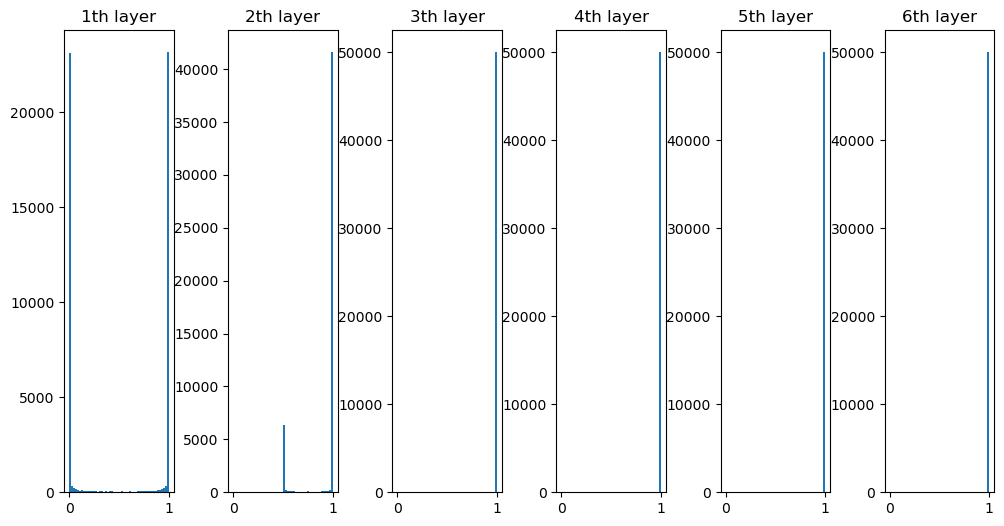

In [829]:
plt.figure(figsize=(12, 6))

for i, a in activation_values.items():
    plt.subplot(1, len(activation_values), i + 1)
    plt.title(f"{i + 1}th layer")
    plt.hist(a.flatten(), bins=50, range=(0, 1))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

### 초기값 : 정규분포(nomalization)
- 활성화함수를 통과하면 양쪽으로 퍼짐

- 0과 1에 퍼지면서 기울기 소실문제(gradient vanishing) 발생

In [830]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 50)
nodes = 50
hideen_layers = 6
activation_values = {}

for i in range(hideen_layers):
    if i != 0:
        x = activation_values[i - 1]
    
    w = np.random.randn(nodes, nodes)
    a = np.dot(x, w)
    z = sigmoid(a)
    activation_values[i] = z

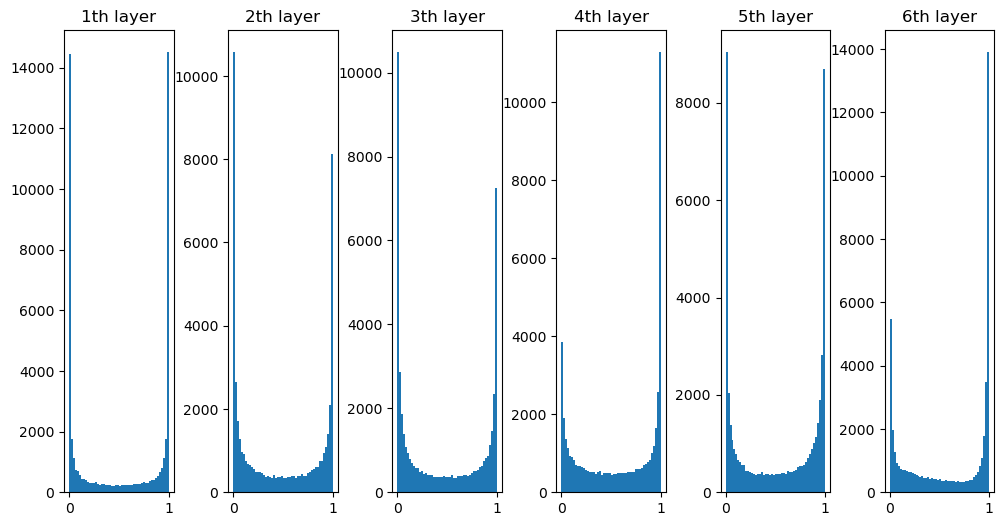

In [831]:
plt.figure(figsize=(12, 6))

for i, a in activation_values.items():
    plt.subplot(1, len(activation_values), i + 1)
    plt.title(f"{i + 1}th layer")
    plt.hist(a.flatten(), bins=50, range=(0, 1))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

### 아주 작은 정규분포값으로 가중치 초기화
- 0과 1로 퍼치지는 않았고, 한 곳에 치우쳐 짐

- 해당 신경망이 표현할 수 있는 문제가 제한됨

In [832]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 50)
nodes = 50
hideen_layers = 6
activation_values = {}

for i in range(hideen_layers):
    if i != 0:
        x = activation_values[i - 1]
    
    w = np.random.randn(nodes, nodes) * 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    activation_values[i] = z

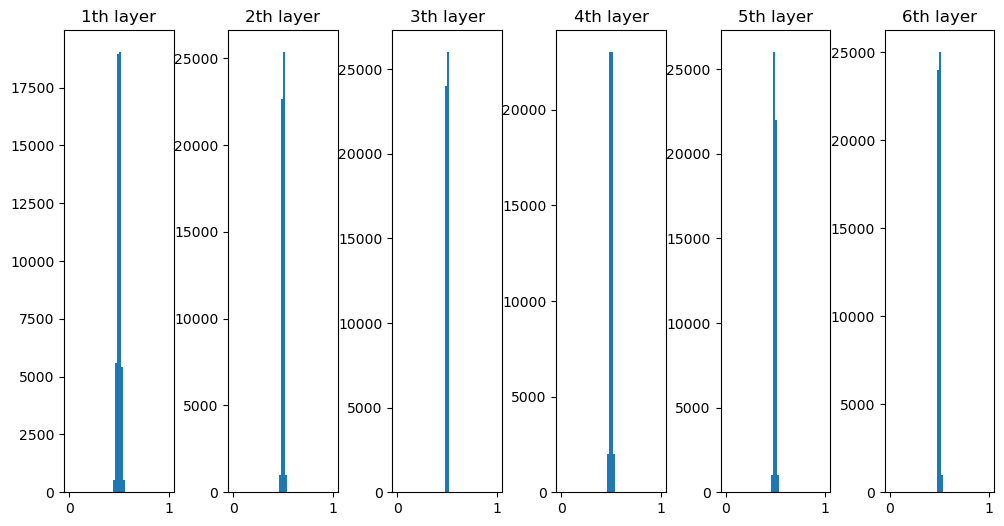

In [833]:
plt.figure(figsize=(12, 6))

for i, a in activation_values.items():
    plt.subplot(1, len(activation_values), i + 1)
    plt.title(f"{i + 1}th layer")
    plt.hist(a.flatten(), bins=50, range=(0, 1))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

### 초기값 : Xavier (Glorot)
- 은닉층의 노드의 수가 n이라면 표준편차가 $\frac{1}{\sqrt{n}}$인 분포

- 더 많은 가중치에 역전파가 전달 가능하고,  
  비교적 많은 문제를 표현할 수 있음

- 활성화 함수가 **선형**인 함수일 때 매우 적합

In [834]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 50)
nodes = 50
hideen_layers = 6
activation_values = {}

for i in range(hideen_layers):
    if i != 0:
        x = activation_values[i - 1]
    
    w = np.random.randn(nodes, nodes) / np.sqrt(nodes)
    a = np.dot(x, w)
    z = sigmoid(a)
    activation_values[i] = z

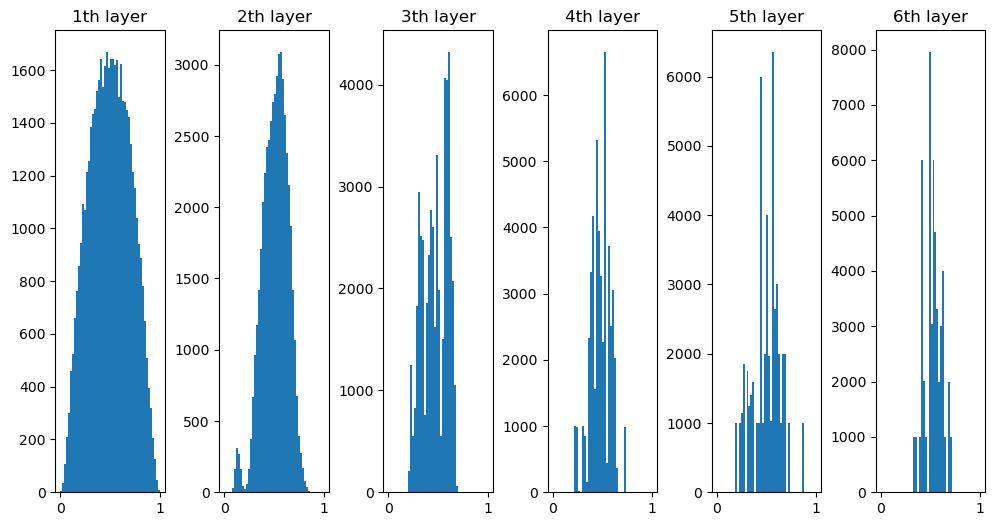

In [835]:
plt.figure(figsize=(12, 6))

for i, a in activation_values.items():
    plt.subplot(1, len(activation_values), i + 1)
    plt.title(f"{i + 1}th layer")
    plt.hist(a.flatten(), bins=50, range=(0, 1))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

### 초기값 : Xavier (Glorot) - tanh
- 활성화 함수: tanh

- sigmoid 함수보다 더 깔끔한 종모양으로 분포  


In [836]:
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

x = np.random.randn(1000, 50)
nodes = 50
hideen_layers = 6
activation_values = {}

for i in range(hideen_layers):
    if i != 0:
        x = activation_values[i - 1]
    
    w = np.random.randn(nodes, nodes) / np.sqrt(nodes)
    a = np.dot(x, w)
    z = tanh(a)
    activation_values[i] = z

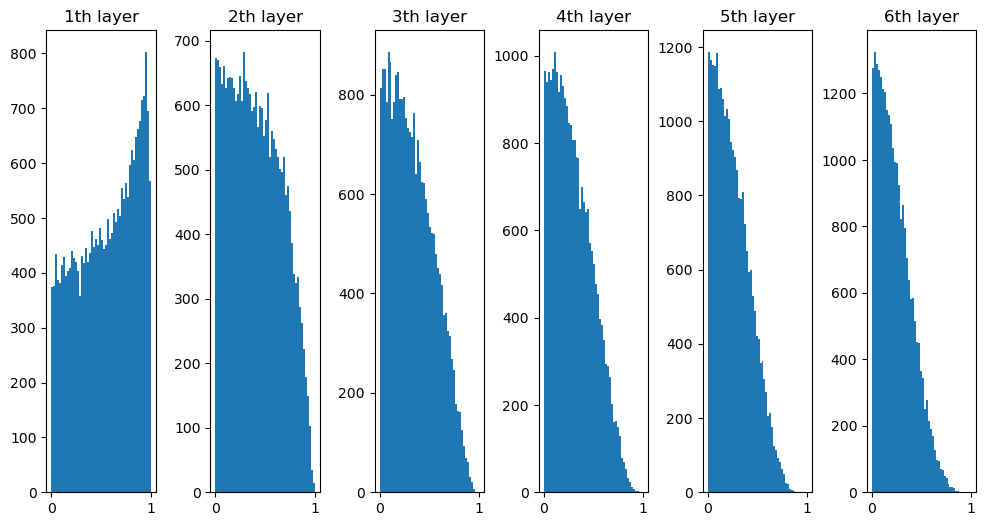

In [837]:
plt.figure(figsize=(12, 6))

for i, a in activation_values.items():
    plt.subplot(1, len(activation_values), i + 1)
    plt.title(f"{i + 1}th layer")
    plt.hist(a.flatten(), bins=50, range=(0, 1))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

## 비선형 함수에서의 가중치 초기화

### 초기값: 0 (Zeros)
- 활성화함수: ReLU

In [838]:
def ReLU(x):
    return np.maximum(0, x)

x = np.random.randn(1000, 50)
nodes = 50
hideen_layers = 6
activation_values = {}

for i in range(hideen_layers):
    if i != 0:
        x = activation_values[i - 1]
    
    w = np.zeros((nodes, nodes))
    a = np.dot(x, w)
    z = ReLU(a)
    activation_values[i] = z

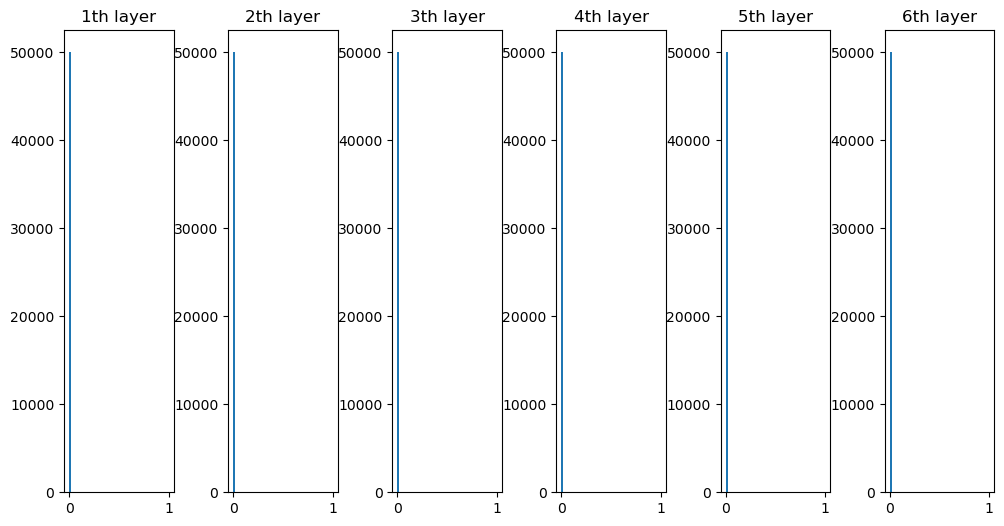

In [839]:
plt.figure(figsize=(12, 6))

for i, a in activation_values.items():
    plt.subplot(1, len(activation_values), i + 1)
    plt.title(f"{i + 1}th layer")
    plt.hist(a.flatten(), bins=50, range=(0, 1))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

### 초기값: 정규분포(Nomalization)
- 활성화함수 : ReLU

In [840]:
def ReLU(x):
    return np.maximum(0, x)

x = np.random.randn(1000, 50)
nodes = 50
hideen_layers = 6
activation_values = {}

for i in range(hideen_layers):
    if i != 0:
        x = activation_values[i - 1]
    
    w = np.random.randn(nodes, nodes)
    a = np.dot(x, w)
    z = ReLU(a)
    activation_values[i] = z

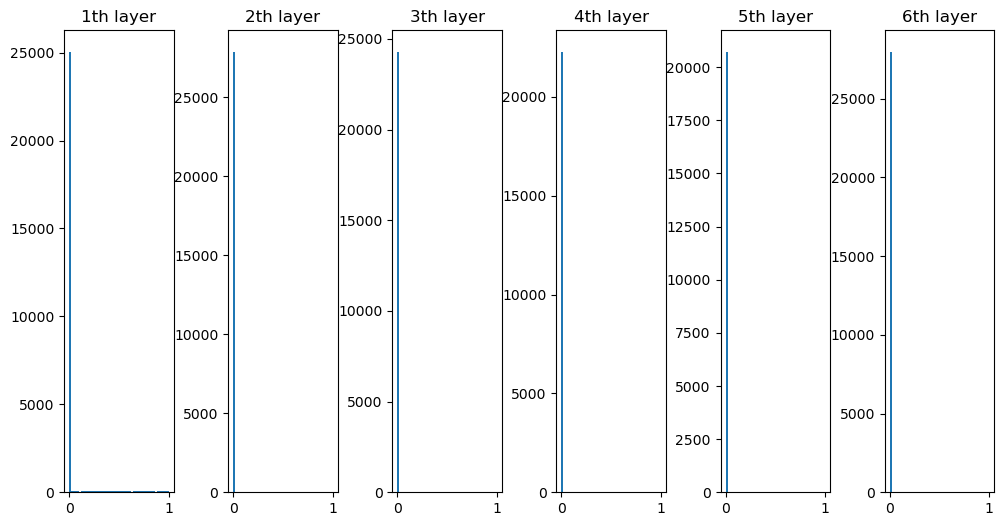

In [841]:
plt.figure(figsize=(12, 6))

for i, a in activation_values.items():
    plt.subplot(1, len(activation_values), i + 1)
    plt.title(f"{i + 1}th layer")
    plt.hist(a.flatten(), bins=50, range=(0, 1))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

#### 표준편차: 0.01 일 때

In [842]:
def ReLU(x):
    return np.maximum(0, x)

x = np.random.randn(1000, 50)
nodes = 50
hideen_layers = 6
activation_values = {}

for i in range(hideen_layers):
    if i != 0:
        x = activation_values[i - 1]
    
    w = np.random.randn(nodes, nodes) * 0.01
    a = np.dot(x, w)
    z = ReLU(a)
    activation_values[i] = z

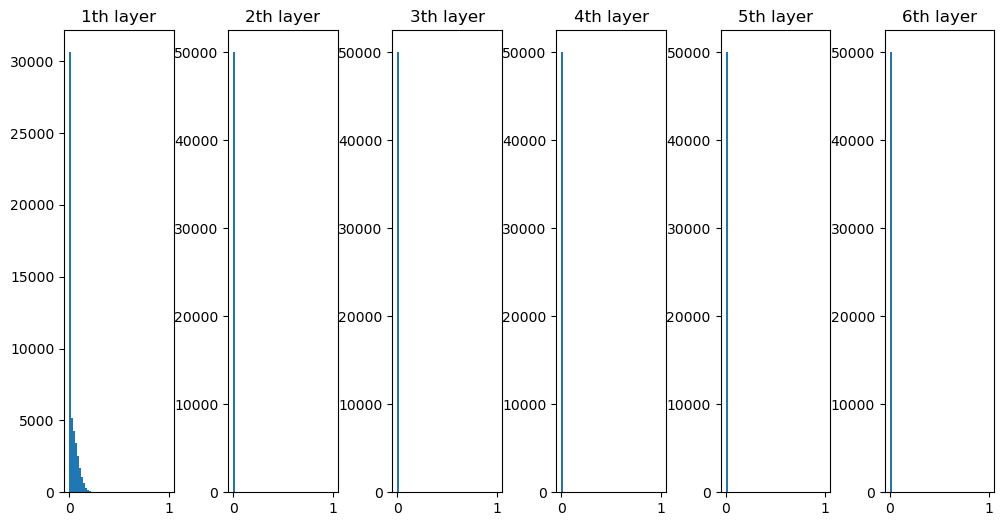

In [843]:
plt.figure(figsize=(12, 6))

for i, a in activation_values.items():
    plt.subplot(1, len(activation_values), i + 1)
    plt.title(f"{i + 1}th layer")
    plt.hist(a.flatten(), bins=50, range=(0, 1))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

### 초기값 : Xavier (Glorot)

In [844]:
def ReLU(x):
    return np.maximum(0, x)

x = np.random.randn(1000, 50)
nodes = 50
hideen_layers = 6
activation_values = {}

for i in range(hideen_layers):
    if i != 0:
        x = activation_values[i - 1]
    
    w = np.random.randn(nodes, nodes) / np.sqrt(nodes)
    a = np.dot(x, w)
    z = ReLU(a)
    activation_values[i] = z

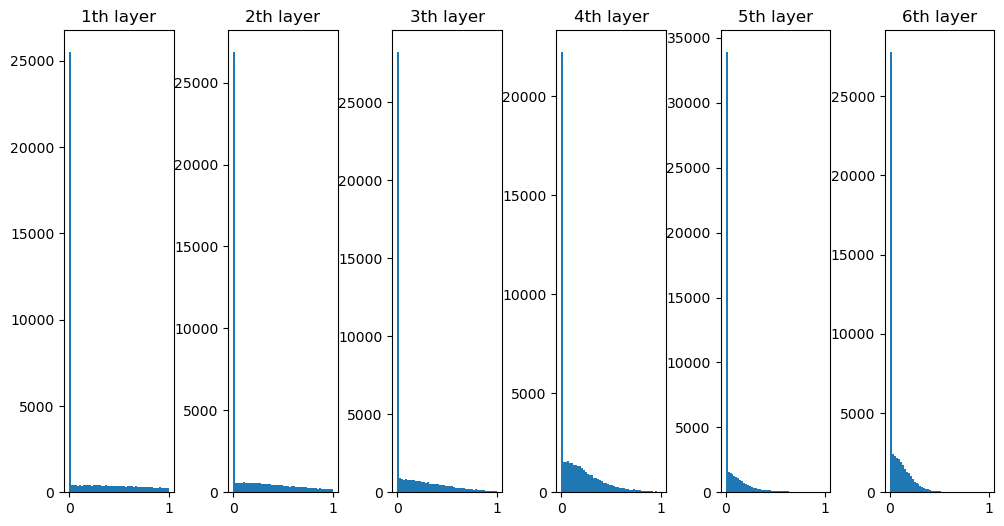

In [845]:
plt.figure(figsize=(12, 6))

for i, a in activation_values.items():
    plt.subplot(1, len(activation_values), i + 1)
    plt.title(f"{i + 1}th layer")
    plt.hist(a.flatten(), bins=50, range=(0, 1))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

### 초기값 : He
- 표준편차가 $\sqrt{\frac{2}{n}}$인 분포

- 활성화값 분포가 균일하게 분포되어 있음

- 활성화함수가 ReLU와 같은 **비선형**함수 일 때 더 적합하다고 알려진 분포

In [846]:
def ReLU(x):
    return np.maximum(0, x)

x = np.random.randn(1000, 50)
nodes = 50
hideen_layers = 6
activation_values = {}

for i in range(hideen_layers):
    if i != 0:
        x = activation_values[i - 1]
    
    w = np.random.randn(nodes, nodes) * np.sqrt(2 / nodes)
    a = np.dot(x, w)
    z = ReLU(a)
    activation_values[i] = z

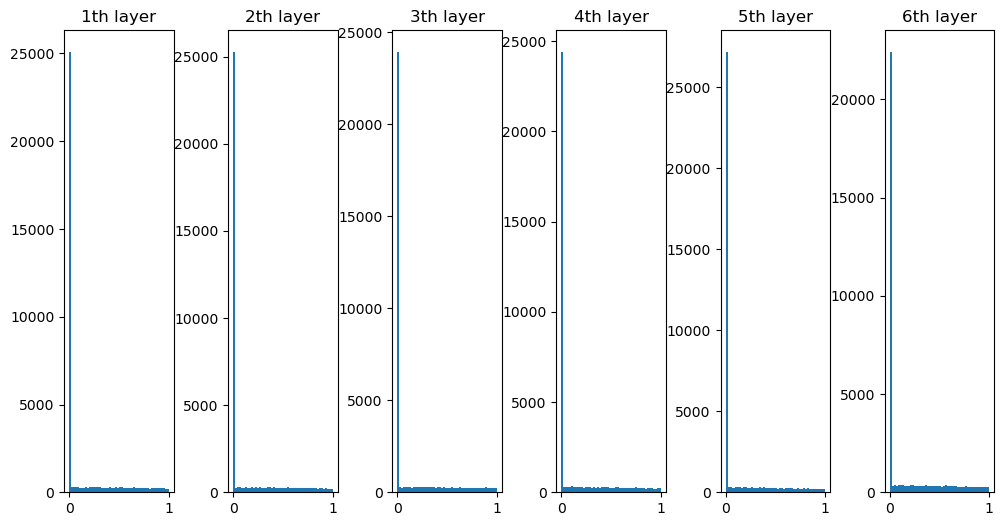

In [847]:
plt.figure(figsize=(12, 6))

for i, a in activation_values.items():
    plt.subplot(1, len(activation_values), i + 1)
    plt.title(f"{i + 1}th layer")
    plt.hist(a.flatten(), bins=50, range=(0, 1))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

## 배치 정규화 (Batch Normalization)

- 가중치의 활성화값이 적당히 퍼지게끔 '강제'로 적용시키는 것

- 미니배치 단위로 데이터의 평균이 0, 표준편차가 1로 정규화

- 학습을 빨리 진행할 수 있음

- 초기값에 크게 의존하지 않아도 됨

- 과적합을 방지

- 보통 Fully-Connected와 활성화함수(비선형) 사이에 놓임

![](https://www.jeremyjordan.me/content/images/2018/01/Screen-Shot-2018-01-23-at-2.27.20-PM.png)

<sub>출처: https://www.jeremyjordan.me/batch-normalization/</sub>

In [848]:
class BatchNormalizer():
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None

        self.running_mean = running_mean
        self.running_var = running_var

        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, input_data, is_train=True):
        self.input_shape = input_data.shape
        if input_data.ndim != 2:
            N, C, H, W = input_data.shape
            input_data = input_data.reshape(N, -1)
        
        out = self.__forward(input_data, is_train)

        return out.reshape(*self.input_shape)
    
    def __forward(self, input_data, is_train):
        if self.running_mean is None:
            N, D = input_data.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)

        if is_train:
            mu = input_data.mean(axis=0)
            xc = input_data - mu
            var = np.mean(xc ** 2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std

            self.batch_size = input_data.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
        else:
            xc = input_data - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
        
        out = self.gamma * xn + self.beta
        return out
    
    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)
        
        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx
    
    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size

        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx

## 과대적합(Overfitting) / 과소적합(Underfitting)

![](https://miro.medium.com/max/2400/1*UCd6KrmBxpzUpWt3bnoKEA.png)

<sub>출처: https://towardsdatascience.com/underfitting-and-overfitting-in-machine-learning-and-how-to-deal-with-it-6fe4a8a49dbf</sub>

### 과대적합 (Overfitting, 오버피팅)
- 모델이 학습 데이터에 한에서만 좋은 성능을 보이고 새로운 데이터에는 그렇지 못한 경우

- 학습 데이터가 매우 적을 경우

- 모델이 지나치게 복잡한 경우

- 학습 횟수가 매우 많을 경우

<br>

- 해결방안
  - 학습 데이터를 다양하게 수집

  - 모델을 단순화
    - 파라미터가 적은 모델을 선택하거나, 학습 데이터의 특성 수를 줄이거나
  
  - 정규화(Regularization)을 통한 규칙을 단순화

  - 적정한 하이퍼 파라미터 찾기

### 과소적합 (Underfitting, 언더피팅)
- 학습 데이터를 충분히 학습하지 않아 성능이 매우 안 좋을 경우

- 모델이 지나치게 단순한 경우

<br>

- 해결방안
  - 충분한 학습 데이터 수집

  - 보다 더 복잡한 모델

  - 에폭수(epochs)를 늘려 충분히 학습

## 규제화(Regularization) - 가중치 감소

- 과대적합(Overfitting, 오버피팅)을 방지하는 방법 중 하나

- 과대적합은 가중치의 매개변수 값이 커서 발생하는 경우가 많음  
  이를 방지하기 위해 **큰 가중치 값에 큰 규제를 가하는 것**

- 규제란 가중치의 절댓값을 가능한 작게 만드는 것으로,  
  가중치의 모든 원소를 0에 가깝게 하여 모든 특성이 출력에 주는 영향을 최소한으로 만드는 것(기울기를 작게 만드는 것)을 의미한다.  
  즉, 규제란 과대적합이 되지 않도록 모델을 강제로 제한한다는 의미

- 적절한 규제값을 찾는 것이 중요.


### L2 규제
- 가중치의 제곱합

- 손실 함수일정 값을 더함으로써 과적합을 방지

- $\lambda$ 값이 크면 가중치 감소가 커지고,  
  작으면 가하는 규제가 적어진다.

- 더 Robust한 모델을 생성하므로 L1보다 많이 사용됨

<br>

## $\qquad Cost = \frac{1}{n} \sum{^n}_{i=1} {L(y_i, \hat{y_i}) + \frac{\lambda}{2}w^2}$

### $\quad L(y_i, \hat{y_i})$ : 기존 Cost Function

In [849]:
# def loss(X, true_y):
#     weight_decay += 0.5 * weight_decay_lambda * np.sum(W ** 2)
    # return weight_decay

### L1 규제
- 가중치의 절대값합

- L2 규제와 달리 어떤 가중치는 0이 되는데 이는 모델이 가벼워짐을 의미

<br>

## $\qquad Cost = \frac{1}{n} \sum{^n}_{i=1} {L(y_i, \hat{y_i}) + \frac{\lambda}{2}|w|}$

### $\quad L(y_i, \hat{y_i})$ : 기존 Cost Function

In [850]:
# def loss(X, true_y):
#     weight_decay += 0.5 * weight_decay_lambda * np.sum(np.abs(W))
    # return weight_decay

## 드롭아웃(Dropout)

- 과적합을 방지하기 위한 방법

- 학습할 때 사용하는 노드의 수를 전체 노드 중에서 **일부만을 사용**

- 보통 ratio_value는 0.5 또는 0.7

![](https://miro.medium.com/max/981/1*EinUlWw1n8vbcLyT0zx4gw.png)

<sub>출처: https://medium.com/konvergen/understanding-dropout-ddb60c9f98aa</sub>

In [851]:
class Dropout():
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, input_data, is_train=True):
        if is_train:
            self.mask = np.random.rand(*input_data.shape) > self.dropout_ratio
            return input_data * self.mask
        else:
            return input_data * (1.0 - self.dropout_ratio)
    
    def backward(self, dout):
        return dout * self.mask

## 하이퍼 파라미터(Hyper Parameter)

### 학습률(Learning Rate)
- 적절한 학습률에 따라 학습정도가 달라짐  
  **적당한** 학습률을 찾는 것이 핵심

### 학습 횟수(Epochs)
- 학습 횟수를 너무 작게, 또는 너무 크게 지정하면  
  과소적합 또는 과적합을 띈다.

- 몇 번씩 진행하면서 최적의 epochs값을 찾아야한다.

### 미니배치 크기(Mini Batch Size)
- 미니 배치 학습
  - 한번 학습할 때 메모리의 부족현상을 막기 위해  
    전체 데이터의 일부를 여러번 학습하는 방식

- 한번 학습할 때마다 얼마만큼의 미니배치 크기를 사용할지 결정

- 배치 크기가 작을수록 학습 시간이 많이 소요되고,  
  클수록 학습 시간이 학습 시간은 적게 소요된다.  
  

### 검증데이터(Validation Data)
- 주어진 데이터를  
  학습 + 검증 + 테스트 데이터로 구분하여 과적합을 방지

- 일반적으로 전체 데이터의 2~30%를 테스트 데이터,  
  나머지에서 20%정도를 검증용 데이터,  
  남은 부분을 학습용 데이터로 사용

![](https://miro.medium.com/max/1400/1*4G__SV580CxFj78o9yUXuQ.png)

<sub>출처: https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6</sub>

## MNIST 분류

### Modules Import

In [852]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

### 데이터 로드

In [853]:
np.random.seed(42)

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = 10

### 데이터 전처리

In [854]:
x_train = x_train[:10000]
x_test = x_test[:3000]
y_train = y_train[:10000]
y_test = y_test[:3000]

In [855]:
print(y_train)

[5 0 4 ... 6 9 7]


In [856]:
x_train, x_test = x_train.reshape(-1, x_train.shape[1] * x_train.shape[2]).astype(np.float32), x_test.reshape(-1, x_test.shape[1] * x_test.shape[2]).astype(np.float32)

x_train = x_train / 255
x_test = x_test / 255
y_train = np.eye(num_classes)[y_train]

In [857]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(10000, 784) (10000, 10) (3000, 784) (3000,)


### Hyper Parameters

In [858]:
epochs = 1000
lr = 1e-2
batch_size = 256
train_size = x_train.shape[0]
iter_per_epoch = max(train_size / batch_size, 1)

### Util Functions

In [859]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t) ** 2)

def cross_entropy_error(pred_y, true_y):
    if pred_y.ndim == 1:
        true_y = true_y.reshape(1, true_y.size)
        pred_y = pred_y.reshape(1, pred_y.size)
    
    if true_y.size == pred_y.size:
        true_y = true_y.argmax(axis=1)
    
    batch_size = pred_y.shape[0]
    return -np.sum(np.log(pred_y[np.arange(batch_size), true_y] + 1e-7)) / batch_size
        

### Util Classes

#### ReLU

In [860]:
class ReLU():
    def __init__(self):
        self.mask = None

    def forward(self, input_data):
        self.mask = (input_data) <= 0
        out = input_data.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

#### Sigmoid

In [861]:
class Sigmoid():
    def __init__(self):
        self.out = None
    
    def forward(self, input_data):
        out = 1 / (1 + np.exp(-input_data))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

#### Layer

In [862]:
class Layer():
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.input_data = None
        self.input_data_shape = None

        self.dW = None
        self.db = None

    def forward(self, input_data):
        self.input_data_shape = input_data.shape
        
        input_data = input_data.reshape(input_data.shape[0], -1)
        self.input_data = input_data
        out = np.dot(self.input_data, self.W) + self.b

        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.input_data.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.input_data_shape)

        return dx

#### Batch Normalization

In [863]:
class BatchNormalizer():
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None

        self.running_mean = running_mean
        self.running_var = running_var

        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, input_data, is_train=True):
        self.input_shape = input_data.shape
        if input_data.ndim != 2:
            N, C, H, W = input_data.shape
            input_data = input_data.reshape(N, -1)
        
        out = self.__forward(input_data, is_train)

        return out.reshape(*self.input_shape)
    
    def __forward(self, input_data, is_train):
        if self.running_mean is None:
            N, D = input_data.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)

        if is_train:
            mu = input_data.mean(axis=0)
            xc = input_data - mu
            var = np.mean(xc ** 2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std

            self.batch_size = input_data.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
        else:
            xc = input_data - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
        
        out = self.gamma * xn + self.beta
        return out
    
    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)
        
        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx
    
    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size

        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx

#### Dropout


In [864]:
class Dropout():
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, input_data, is_train=True):
        if is_train:
            self.mask = np.random.rand(*input_data.shape) > self.dropout_ratio
            return input_data * self.mask
        else:
            return input_data * (1.0 - self.dropout_ratio)
    
    def backward(self, dout):
        return dout * self.mask

#### Softmax

In [865]:
class Softmax():
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, input_data, t):
        self.t = t
        self.y = softmax(input_data)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

## Model

In [866]:
class MyModel():
    def __init__(self, input_size, hidden_size_list, output_size, activation="relu", decay_lambda=0, use_dropout=False, dropout_ratio=0.5, use_batchnorm=False):
        self.input_size = input_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num= len(hidden_size_list)
        self.output_size = output_size
        self.decay_lambda = decay_lambda
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm
        self.params = {}

        self.__init_weight(activation)

        activation_layer = {"sigmoid": Sigmoid, "relu": ReLU}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num + 1):
            self.layers[f"Layer{idx}"] = Layer(self.params[f"W{idx}"], self.params[f"b{idx}"])

            if self.use_batchnorm:
                self.params[f"gamma{idx}"] = np.ones(self.hidden_size_list[idx - 1])
                self.params[f"beta{idx}"] = np.zeros(self.hidden_size_list[idx - 1])
                self.layers[f"BatchNorm{idx}"] = BatchNormalizer(self.params[f"gamma{idx}"], self.params[f"beta{idx}"])
            
            self.layers[f"Activation_function{idx}"] = activation_layer[activation]()

            if self.use_dropout:
                self.layers[f"Dropout{idx}"] = Dropout(dropout_ratio)
            
        idx = self.hidden_layer_num + 1
        self.layers[f"Layer{idx}"] = Layer(self.params[f"W{idx}"], self.params[f"b{idx}"])
        self.last_layer = Softmax()
        
    def __init_weight(self, activation):
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]

        for idx in range(1, len(all_size_list)):
            scale = None
            if activation.lower() == "relu":
                scale = np.sqrt(2.0 / all_size_list[idx - 1])
            elif activation.lower() == "sigmoid":
                scale = np.sqrt(1.0 / all_size_list[idx - 1])
            
            self.params[f"W{idx}"] = scale * np.random.randn(all_size_list[idx - 1], all_size_list[idx])
            self.params[f"b{idx}"] = np.zeros(all_size_list[idx])
    
    def predict(self, x, is_train=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, is_train)
            else:
                x = layer.forward(x)
        
        return x
    
    def loss(self, x, t, is_train=False):
        y = self.predict(x, is_train)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params[f"W{idx}"]
            weight_decay += 0.5 * self.decay_lambda * np.sum(W ** 2)
        
        return self.last_layer.forward(y, t) + weight_decay
    
    def accuracy(self, x, t):
        y = self.predict(x, is_train=False)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        
        return accuracy
    
    def gradient(self, x, t):
        self.loss(x, t, is_train=True)
        
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}

        for idx in range(1, self.hidden_layer_num + 2):
            grads[f"W{idx}"] = self.layers[f"Layer{idx}"].dW + self.decay_lambda * self.params[f"W{idx}"]
            grads[f"b{idx}"] = self.layers[f"Layer{idx}"].db

            if self.use_batchnorm and idx != self.hidden_layer_num + 1:
                grads[f"gamma{idx}"] = self.layers[f"BatchNorm{idx}"].dgamma
                grads[f"beta{idx}"] = self.layers[f"BatchNorm{idx}"].dbeta
        
        return grads

### 모델 생성 및 학습 1
- 사용한 기법
  - 학습데이터 수 10,000

  - Hidden Layers : 4
    - [100, 100, 100, 100]
  - SGD
  - EPOCHS : 1000
  - 학습률 : 1e-2 (0.01)
  - 배치사이즈 : 256
  - 드롭아웃 : 0.2
  - 배치 정규화
  - 규제화 : 0.1

In [867]:
decay_lambda = 0.1
model_1 = MyModel(input_size=784, hidden_size_list=[256, 100, 64, 32], output_size=10, decay_lambda=decay_lambda, use_batchnorm=True)

In [868]:
optimizer = SGD(lr=lr)

In [869]:
model_1_train_loss_list = []
model_1_train_acc_list = []
model_1_test_acc_list = []

In [870]:
for epoch in range(epochs):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grads = model_1.gradient(x_batch, y_batch)
    optimizer.update(model_1.params, grads)

    loss = model_1.loss(x_batch, y_batch)
    model_1_train_loss_list.append(loss)

    train_acc = model_1.accuracy(x_train, y_train)
    test_acc = model_1.accuracy(x_test, y_test)
    model_1_train_acc_list.append(train_acc)
    model_1_test_acc_list.append(test_acc)

    if epoch % 50 == 0:
        print(f"[Model 1] Epoch: {epoch + 1} Train Loss: {loss:.4f} Train Accuracy: {train_acc:.4f} Test Accuracy: {test_acc:.4f}")


[Model 1] Epoch: 1 Train Loss: 60.2694 Train Accuracy: 0.1011 Test Accuracy: 0.1027


[Model 1] Epoch: 51 Train Loss: 43.0785 Train Accuracy: 0.5929 Test Accuracy: 0.5273
[Model 1] Epoch: 101 Train Loss: 38.8311 Train Accuracy: 0.7529 Test Accuracy: 0.6760
[Model 1] Epoch: 151 Train Loss: 35.0980 Train Accuracy: 0.8141 Test Accuracy: 0.7387
[Model 1] Epoch: 201 Train Loss: 31.6798 Train Accuracy: 0.8513 Test Accuracy: 0.7753
[Model 1] Epoch: 251 Train Loss: 28.7016 Train Accuracy: 0.8773 Test Accuracy: 0.8080
[Model 1] Epoch: 301 Train Loss: 26.0096 Train Accuracy: 0.8919 Test Accuracy: 0.8287
[Model 1] Epoch: 351 Train Loss: 23.5795 Train Accuracy: 0.9056 Test Accuracy: 0.8467
[Model 1] Epoch: 401 Train Loss: 21.4177 Train Accuracy: 0.9148 Test Accuracy: 0.8570
[Model 1] Epoch: 451 Train Loss: 19.5229 Train Accuracy: 0.9243 Test Accuracy: 0.8707
[Model 1] Epoch: 501 Train Loss: 17.6738 Train Accuracy: 0.9304 Test Accuracy: 0.8770
[Model 1] Epoch: 551 Train Loss: 15.9810 Train Accuracy: 0.9385 Test Accuracy: 0.8810
[Model 1] Epoch: 601 Train Loss: 14.4494 Train Accuracy

#### 시각화

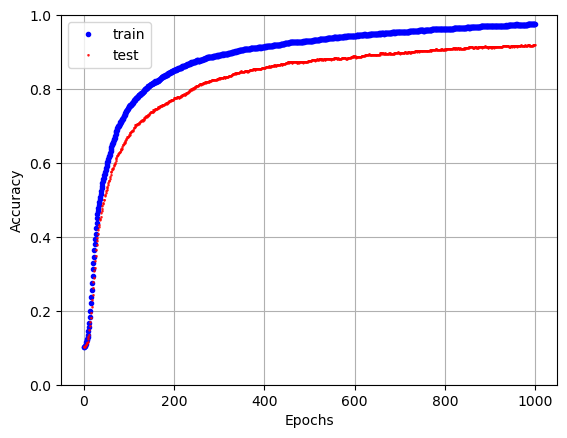

In [871]:
x = np.arange(len(model_1_train_acc_list))

plt.plot(x, model_1_train_acc_list, "bo", label="train", markersize=3)
plt.plot(x, model_1_test_acc_list, "rv", label="test", markersize=1)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.ylim(0, 1.0)
plt.legend()
plt.show()

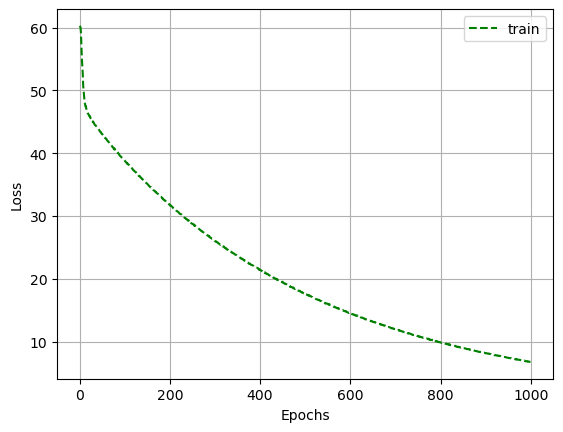

In [872]:
x = np.arange(len(model_1_train_loss_list))

plt.plot(x, model_1_train_loss_list, "g--", label="train", markersize=3)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

plt.show()

### 모델 생성 및 학습 2
- 사용한 기법
  - 학습데이터 수 10,000

  - Hidden Layers = 4
    - [100, 100, 100, 100]
  - Adam
  - EPOCHS : 1000
  - 학습률 : 1e-3 (0.001)
  - 배치사이즈 : 100
  - 드롭아웃 : 0.5
  - 배치 정규화
  - 규제화 : 0.15

In [873]:
np.random.seed(42)

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = 10

x_train = x_train[:10000]
x_test = x_test[:3000]
y_train = y_train[:10000]
y_test = y_test[:3000]

x_train, x_test = x_train.reshape(-1, x_train.shape[1] * x_train.shape[2]).astype(np.float32), x_test.reshape(-1, x_test.shape[1] * x_test.shape[2]).astype(np.float32)

x_train = x_train / 255
x_test = x_test / 255
y_train = np.eye(num_classes)[y_train]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10000, 784), (10000, 10), (3000, 784), (3000,))

In [874]:
epochs = 1000
lr = 1e-3
batch_size = 100
train_size = x_train.shape[0]
iter_per_epoch = max(train_size / batch_size, 1)

In [875]:
decay_lambda_2 = 0.15
model_2 = MyModel(input_size=784, hidden_size_list=[100, 100, 100, 100], decay_lambda=decay_lambda_2, output_size=10, use_dropout=True, dropout_ratio=0.5, use_batchnorm=True)
optimizer = Adam(lr=lr)

model_2_train_loss_list = []
model_2_train_acc_list = []
model_2_test_acc_list = []

In [876]:
for epoch in range(epochs):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grads = model_2.gradient(x_batch, y_batch)
    optimizer.update(model_2.params, grads)

    loss = model_2.loss(x_batch, y_batch)
    model_2_train_loss_list.append(loss)

    train_acc = model_2.accuracy(x_train, y_train)
    test_acc = model_2.accuracy(x_test, y_test)
    model_2_train_acc_list.append(train_acc)
    model_2_test_acc_list.append(test_acc)

    if epoch % 50 == 0:
        print(f"[Model 2] Epoch: {epoch + 1} Train Loss: {loss:.4f} Train Accuracy: {train_acc:.4f} Test Accuracy: {test_acc:.4f}")


[Model 2] Epoch: 1 Train Loss: 75.1684 Train Accuracy: 0.0765 Test Accuracy: 0.0790
[Model 2] Epoch: 51 Train Loss: 32.3736 Train Accuracy: 0.3927 Test Accuracy: 0.3387
[Model 2] Epoch: 101 Train Loss: 18.4314 Train Accuracy: 0.4613 Test Accuracy: 0.3867
[Model 2] Epoch: 151 Train Loss: 11.2643 Train Accuracy: 0.6037 Test Accuracy: 0.5317
[Model 2] Epoch: 201 Train Loss: 7.1645 Train Accuracy: 0.6907 Test Accuracy: 0.6303
[Model 2] Epoch: 251 Train Loss: 4.8652 Train Accuracy: 0.7169 Test Accuracy: 0.6663
[Model 2] Epoch: 301 Train Loss: 3.4816 Train Accuracy: 0.7525 Test Accuracy: 0.7110
[Model 2] Epoch: 351 Train Loss: 2.4715 Train Accuracy: 0.7681 Test Accuracy: 0.7370
[Model 2] Epoch: 401 Train Loss: 1.9827 Train Accuracy: 0.7930 Test Accuracy: 0.7593
[Model 2] Epoch: 451 Train Loss: 1.6183 Train Accuracy: 0.7880 Test Accuracy: 0.7447
[Model 2] Epoch: 501 Train Loss: 1.3240 Train Accuracy: 0.7690 Test Accuracy: 0.7327
[Model 2] Epoch: 551 Train Loss: 1.3685 Train Accuracy: 0.7859 T

#### 시각화

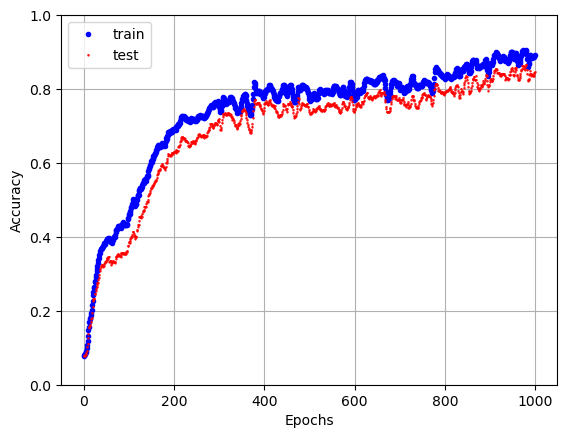

In [877]:
x = np.arange(len(model_2_train_acc_list))

plt.plot(x, model_2_train_acc_list, "bo", label="train", markersize=3)
plt.plot(x, model_2_test_acc_list, "rv", label="test", markersize=1)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.ylim(0, 1.0)
plt.legend()

plt.show()

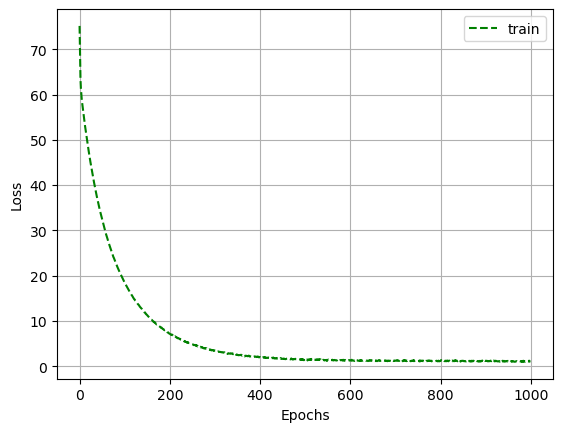

In [878]:
x = np.arange(len(model_2_train_loss_list))

plt.plot(x, model_2_train_loss_list, "g--", label="train", markersize=3)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

plt.show()

### 모델 생성 및 학습 3

- 사용한 기법
  - 학습데이터 수 20,000

  - Hidden Layers = 3
    - [256, 100, 100]
  - Adam
  - EPOCHS : 1000
  - 학습률 : 1e-2 (0.01)
  - 배치사이즈 : 100
  - 배치정규화



In [879]:
np.random.seed(42)

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = 10

x_train = x_train[:20000]
x_test = x_test[:3000]
y_train = y_train[:20000]
y_test = y_test[:3000]

x_train, x_test = x_train.reshape(-1, x_train.shape[1] * x_train.shape[2]).astype(np.float32), x_test.reshape(-1, x_test.shape[1] * x_test.shape[2]).astype(np.float32)

x_train = x_train / 255
x_test = x_test / 255
y_train = np.eye(num_classes)[y_train]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((20000, 784), (20000, 10), (3000, 784), (3000,))

In [880]:
epochs = 1000
lr = 1e-2
batch_size = 100
train_size = x_train.shape[0]
iter_per_epoch = max(train_size / batch_size, 1)

In [881]:
decay_lambda_3 = 0
model_3 = MyModel(input_size=784, hidden_size_list=[256, 100, 100], decay_lambda=decay_lambda_3, output_size=10, use_dropout=True, dropout_ratio=0.5, use_batchnorm=True)
optimizer = Adam(lr=lr)

model_3_train_loss_list = []
model_3_train_acc_list = []
model_3_test_acc_list = []

In [883]:
for epoch in range(epochs):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grads = model_3.gradient(x_batch, y_batch)
    optimizer.update(model_3.params, grads)

    loss = model_3.loss(x_batch, y_batch)
    model_3_train_loss_list.append(loss)

    train_acc = model_3.accuracy(x_train, y_train)
    test_acc = model_3.accuracy(x_test, y_test)
    model_3_train_acc_list.append(train_acc)
    model_3_test_acc_list.append(test_acc)

    if epoch % 50 == 0:
        print(f"[Model 3] Epoch: {epoch + 1} Train Loss: {loss:.4f} Train Accuracy: {train_acc:.4f} Test Accuracy: {test_acc:.4f}")


[Model 3] Epoch: 1 Train Loss: 9.6658 Train Accuracy: 0.1437 Test Accuracy: 0.1233
[Model 3] Epoch: 51 Train Loss: 0.2196 Train Accuracy: 0.8988 Test Accuracy: 0.8677
[Model 3] Epoch: 101 Train Loss: 0.4516 Train Accuracy: 0.9146 Test Accuracy: 0.8857
[Model 3] Epoch: 151 Train Loss: 0.2658 Train Accuracy: 0.9335 Test Accuracy: 0.9033
[Model 3] Epoch: 201 Train Loss: 0.3008 Train Accuracy: 0.9428 Test Accuracy: 0.9163
[Model 3] Epoch: 251 Train Loss: 0.1569 Train Accuracy: 0.9476 Test Accuracy: 0.9187
[Model 3] Epoch: 301 Train Loss: 0.1336 Train Accuracy: 0.9486 Test Accuracy: 0.9230
[Model 3] Epoch: 351 Train Loss: 0.1588 Train Accuracy: 0.9510 Test Accuracy: 0.9277
[Model 3] Epoch: 401 Train Loss: 0.2122 Train Accuracy: 0.9575 Test Accuracy: 0.9347
[Model 3] Epoch: 451 Train Loss: 0.0797 Train Accuracy: 0.9609 Test Accuracy: 0.9347
[Model 3] Epoch: 501 Train Loss: 0.0291 Train Accuracy: 0.9656 Test Accuracy: 0.9400
[Model 3] Epoch: 551 Train Loss: 0.0603 Train Accuracy: 0.9651 Test 

#### 시각화

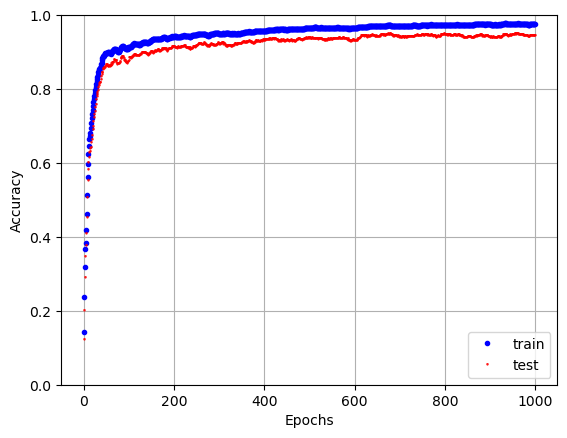

In [884]:
x = np.arange(len(model_3_train_acc_list))

plt.plot(x, model_3_train_acc_list, "bo", label="train", markersize=3)
plt.plot(x, model_3_test_acc_list, "rv", label="test", markersize=1)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.ylim(0, 1.0)
plt.legend()

plt.show()

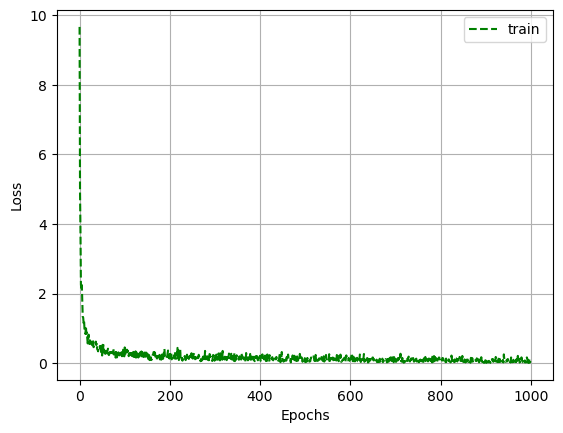

In [885]:
x = np.arange(len(model_3_train_loss_list))

plt.plot(x, model_3_train_loss_list, "g--", label="train", markersize=3)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

plt.show()

### 3가지 모델 비교
- 위의 3가지 모델은 전체적으로 학습 데이터 수를 일부로 제한했기 때문에 학습이 잘 안 될 가능성이 높음  
  - 따라서 여러 학습 기술들을 적용함


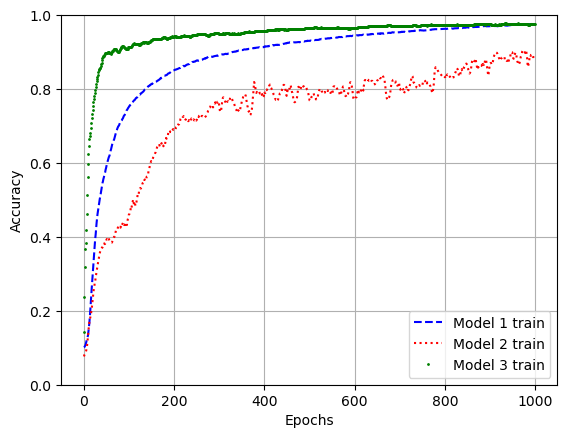

In [888]:
x = np.arange(len(model_3_train_acc_list))

plt.plot(x, model_1_train_acc_list, "b--", label="Model 1 train", markersize=1)
plt.plot(x, model_2_train_acc_list, "r:", label="Model 2 train", markersize=1)
plt.plot(x, model_3_train_acc_list, "go", label="Model 3 train", markersize=1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.ylim(0, 1.0)
plt.legend()

plt.show()